<a href="https://colab.research.google.com/github/ucpcpu/Data-Science/blob/main/Training_the_NN_for_prediction_of_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Training the Neural Network to predict a image by changing the Number of Neurons and Learning Rate





PART A


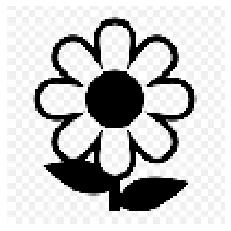

0 0.3590558410396008 0.08547642736917478
50 0.07868237474973185 0.07876366683114495
100 0.07772803922478257 0.07844635476868957
150 0.0791695150824242 0.0780128353701444
200 0.07744065369039964 0.07721223995693642
250 0.07421572443967404 0.07601752492111588
300 0.0718956241505464 0.0736378665638919
350 0.07778979139376427 0.07413506413064946
400 0.06990014334864676 0.0679277193356295
450 0.07021074355412223 0.06869989689310203
500 0.06394381443847137 0.06574908139011125
550 0.07182389833198682 0.0664161014655855
600 0.06315952528358952 0.06654335809766666
650 0.06017404808475867 0.06489160210914248
700 0.06620467573932101 0.06825942502758542
750 0.06662610357504219 0.06698141399587883
800 0.06430611176660761 0.0642008151134665
850 0.06595029401491882 0.06303240544421064
900 0.06899341451183262 0.06323089217748598
950 0.07034169492159179 0.0683906409767694
1000 0.07136073425684702 0.07033411986023129
1050 0.06285885970482943 0.06565533440480163
1100 0.06400478313597414 0.063352782652448

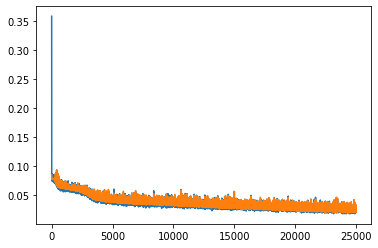

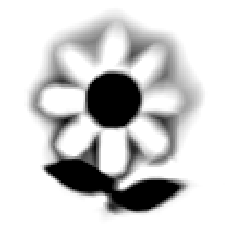

In [ ]:
import numpy as np # for linear algebra
import matplotlib.pyplot as plt # for plotting
import cv2

#Activation function (ReLU)
def y_dydz(z): # calculate sigma(z) and sigma'(z)
     yval=z*(z>0)
     dydz=(z>0)
     return(yval,dydz)

def forward_step(y_in,w,b): # calculate output value of a layer, from input y_in
    z=np.dot(y_in,w)+b # w=weights for synaptic links between layers, b=bias vector for the layer
    #Z is preactivated output
    return(y_dydz(z)) # apply activation function sigma and return output as well as its derivative wrt z

def apply_network(y_in): # One forward propagation through the network
    global Weights, Biases, NLayers
    #NLayers = number of hidden layers + 1 = Number of layers - 1
    global Ylayer, dydz_layer # for storing output from each layer and dy/dz values

    y=y_in
    Ylayer[0]=y #Inputs
    for j in range(NLayers): # loop through all layers, excluding inputlayer
        # j=0 corresponds to the first hidden layer above the input
        y,dydz=forward_step(y,Weights[j],Biases[j]) # one step, into layer j
        dydz_layer[j]=dydz # store sigma'(z), needed later in backprop]
        Ylayer[j+1]=y # store sigma(z), needed later in backprop]
    return(y)

def apply_network_only(y_in): #only one forward pass through the network
    #Same as apply_network() by with no storege of y and dydz
    y=y_in
    for j in range(NLayers):
        y,dydz=forward_step(y,Weights[j],Biases[j])
    return(y)

def backward_step(Delta,w,dy):
    # Delta at layer n, of batchsize x layersize(n))
    # w between n-1 and n [layersize(n-1) x layersize(n) matrix]
    # dy = dy/dz at layer n-1, of batchsize x layersize(n-1)
    return( np.dot(Delta,np.transpose(w))*dy )

def backpropagation(y_true): #one backward pass through the network
    # to calculate dCdW and dCdb and store them
    global Ylayer, dydz_layer, Weights, Biases, NLayers
    global dCdw_layer, dCdb_layer # dCost/dw and dCost/db
    global batchsize

    Delta=(Ylayer[-1]-y_true)*dydz_layer[-1]
    dCdw_layer[-1]=np.dot(np.transpose(Ylayer[-2]),Delta)/batchsize
    dCdb_layer[-1]=np.sum(Delta,axis=0)/batchsize
    for j in range(NLayers-1):
        Delta=backward_step(Delta,Weights[-1-j],dydz_layer[-2-j])
        dCdw_layer[-2-j]=np.dot(np.transpose(Ylayer[-3-j]),Delta)/batchsize
        dCdb_layer[-2-j]=np.sum(Delta,axis=0)/batchsize


####Gradient descent
def gradient_descent(eta): # update weights & biases (after backpropagation)
    global dCdw_layer, dCdb_layer, Weights, Biases
    ##eta is learning rate or step parameter
    for j in range(NLayers):
        Weights[j]-=eta*dCdw_layer[j]
        Biases[j]-=eta*dCdb_layer[j]

def train_one_step(y_in,y_true,eta): # one full training of a batch
    # y_in is an array of size batchsize x number of inputs
    # y_true is an array of size batchsize x number of outputs
    # eta is the stepsize for the gradient descent method
    global y_out

    y_out=apply_network(y_in) #Ylayer, dydz are calculated and stored
    backpropagation(y_true) #dCdw and dCdb are calculated and stored
    gradient_descent(eta)
    cost=0.5*(np.sum((y_true-y_out)**2))/batchsize
    return(cost)

def Validation(y_in,y_true,nvalid): # one full training of a batch
    # y_in is an array of size batchsize x number of inputs
    # y_true is an array of size batchsize x number of outputs
    y_out=apply_network_only(y_in) #Ylayer, dydz are calculated and stored
    cost=0.5*(np.sum((y_true-y_out)**2))/nvalid
    return(cost)

# set up all the layers with neurons
LayerSizes=[2,100,100,100,1] # input,hidden1,hidden2,...,output
NLayers=int(len(LayerSizes)-1) # does not count the input-layer (but does count the output-layer)

# Initialize the weights and biases
Weights=[np.random.uniform(low=-0.1,high=+0.1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NLayers)]
Biases=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]

# set up all the storge lists
Ylayer=[np.zeros(LayerSizes[j]) for j in range(NLayers+1)]
dydz_layer=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]
dCdw_layer=[np.zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NLayers)]
dCdb_layer=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]

#from PIL import Image
# load the pixel image!
pics=cv2.imread('emoji7.png')
pixel_image=np.transpose(pics[:,:,0]) # have to transpose...
pixel_image=pixel_image[:,::-1] # and flip... to get the right view!
pixel_image-=np.min(pixel_image)
pixel_image=(pixel_image.astype(dtype='float'))/pixel_image.max() # normalize between 0 and 1!
Npixels=np.shape(pixel_image)[0] # assuming a square image!

# the function we want to have (desired outcome)
def CustomFunc(x0,x1):
    global pixel_image, Npixels
    # convert to integer coordinates (assuming input is 0..1)
    x0int=(x0*Npixels*0.99999).astype(dtype='int')
    x1int=(x1*Npixels*0.99999).astype(dtype='int')
    return(pixel_image[x0int,x1int]) # extract color values at these pixels

# check that this works:
Npixels_Test=100 # do the test output on a low-res grid! (saves time)
xrange=np.linspace(0,1,Npixels_Test)
x0,x1=np.meshgrid(xrange,xrange)
plt.imshow(CustomFunc(x0,x1), cmap='gray', interpolation='nearest',origin='lower')
plt.axis('off')
#plt.colorbar()
plt.show()

######################################################################################
batchsize=1500
def make_train_batch(): #random postions in a 2D square
    global batchsize

    inputs=np.random.uniform(low=0,high=1,size=[batchsize,2])
    Trueval=np.zeros([batchsize,1]) # must have right dimensions
    Trueval[:,0]=CustomFunc(inputs[:,0],inputs[:,1])
    return(inputs,Trueval)

nvalid=3000
def make_valid_batch(nvalid): #random postions in a 2D square for validation
    inputs=np.random.uniform(low=0,high=1,size=[nvalid,2])
    Trueval=np.zeros([nvalid,1]) # Careful about right dimensions
    Trueval[:,0]=CustomFunc(inputs[:,0],inputs[:,1])
    return(inputs,Trueval)

#Training the Neural network in nsteps
eta=0.75 #learning rate
nsteps=25000
costt=np.zeros(nsteps) #for training samples
costv=np.zeros(nsteps) #for validation samples

valid_inp,valid_out=make_valid_batch(nvalid)
best=100.0
for k in range(nsteps):
    train_inp,train_out=make_train_batch()
    costt[k]=train_one_step(train_inp,train_out,eta)
    costv[k]=Validation(valid_inp,valid_out,nvalid)
    if k%50 == 0:
      print(k,costt[k],costv[k])
    if costv[k] < best: ##store the wights/biases for the best model
        best=costv[k]
        SWeights=Weights
        SBiases=Biases
#        print(k,costt[k],costv[k])

plt.plot(costt)
plt.plot(costv)
plt.show()

###################################################################
#Use the best model for testing
Weights=SWeights
Biases=SBiases

# Testing the model
#In this case test batch includes all the points on the image grid 50x50
test_batchsize=np.shape(x0)[0]*np.shape(x0)[1]
testsample=np.zeros([test_batchsize,2])
testsample[:,0]=np.ndarray.flatten(x0)
testsample[:,1]=np.ndarray.flatten(x1)
# check the output of this net
testoutput=apply_network_only(testsample)
# show this!
myim=plt.imshow(np.reshape(testoutput,np.shape(x0)), cmap='gray', origin='lower',interpolation='nearest',vmin=0.0,vmax=1.0)
plt.axis('off')
#plt.colorbar()
plt.show()

PART B

A) With 32 neurons

B) With 64 neurons

C) With 128 neurons

D) WIth 160 neurons


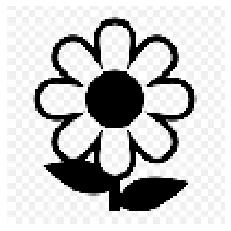

0 0.360936236198873 0.24432741105114497
50 0.07671797190562175 0.07868350767687297
100 0.07694470118933479 0.07868189916186909
150 0.07893345249960207 0.07865312452133344
200 0.0788409788174853 0.07864047036657525
250 0.07961684172266939 0.0786381406063942
300 0.0814084640653091 0.0786667000357693
350 0.08109479072469614 0.07868669324150085
400 0.07736964989667423 0.07857016580972252
450 0.07799090990101325 0.07853644065245896
500 0.07930041662774508 0.07850004908310772
550 0.07948697330349165 0.0784471771305444
600 0.07863012853702066 0.07836402648784925
650 0.08031412663789067 0.07826623290138271
700 0.0810721776232286 0.07814973720400276
750 0.07691818031462423 0.07786987065592986
800 0.0788340298732632 0.077573156899109
850 0.08423869556726375 0.0776054791765272
900 0.07552819006457032 0.07638657271133825
950 0.07429758778219682 0.07564392316847243
1000 0.07873699269570827 0.0739533147680254
1050 0.07148025070849263 0.0721857657793359
1100 0.07422598829432696 0.07186360813899165
11

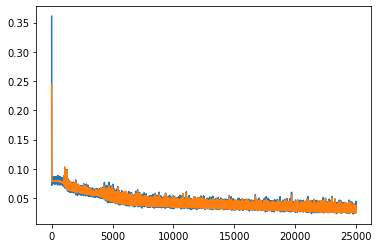

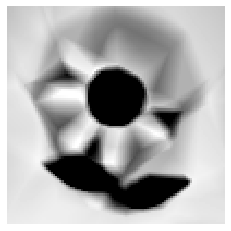

In [ ]:
#b
#32 neurons
import numpy as np # for linear algebra
import matplotlib.pyplot as plt # for plotting
import cv2

#Activation function (ReLU)
def y_dydz(z): # calculate sigma(z) and sigma'(z)
     yval=z*(z>0)
     dydz=(z>0)
     return(yval,dydz)

def forward_step(y_in,w,b): # calculate output value of a layer, from input y_in
    z=np.dot(y_in,w)+b # w=weights for synaptic links between layers, b=bias vector for the layer
    #Z is preactivated output
    return(y_dydz(z)) # apply activation function sigma and return output as well as its derivative wrt z

def apply_network(y_in): # One forward propagation through the network
    global Weights, Biases, NLayers
    #NLayers = number of hidden layers + 1 = Number of layers - 1
    global Ylayer, dydz_layer # for storing output from each layer and dy/dz values

    y=y_in
    Ylayer[0]=y #Inputs
    for j in range(NLayers): # loop through all layers, excluding inputlayer
        # j=0 corresponds to the first hidden layer above the input
        y,dydz=forward_step(y,Weights[j],Biases[j]) # one step, into layer j
        dydz_layer[j]=dydz # store sigma'(z), needed later in backprop]
        Ylayer[j+1]=y # store sigma(z), needed later in backprop]
    return(y)

def apply_network_only(y_in): #only one forward pass through the network
    #Same as apply_network() by with no storege of y and dydz
    y=y_in
    for j in range(NLayers):
        y,dydz=forward_step(y,Weights[j],Biases[j])
    return(y)

def backward_step(Delta,w,dy):
    # Delta at layer n, of batchsize x layersize(n))
    # w between n-1 and n [layersize(n-1) x layersize(n) matrix]
    # dy = dy/dz at layer n-1, of batchsize x layersize(n-1)
    return( np.dot(Delta,np.transpose(w))*dy )

def backpropagation(y_true): #one backward pass through the network
    # to calculate dCdW and dCdb and store them
    global Ylayer, dydz_layer, Weights, Biases, NLayers
    global dCdw_layer, dCdb_layer # dCost/dw and dCost/db
    global batchsize

    Delta=(Ylayer[-1]-y_true)*dydz_layer[-1]
    dCdw_layer[-1]=np.dot(np.transpose(Ylayer[-2]),Delta)/batchsize
    dCdb_layer[-1]=np.sum(Delta,axis=0)/batchsize
    for j in range(NLayers-1):
        Delta=backward_step(Delta,Weights[-1-j],dydz_layer[-2-j])
        dCdw_layer[-2-j]=np.dot(np.transpose(Ylayer[-3-j]),Delta)/batchsize
        dCdb_layer[-2-j]=np.sum(Delta,axis=0)/batchsize


####Gradient descent
def gradient_descent(eta): # update weights & biases (after backpropagation)
    global dCdw_layer, dCdb_layer, Weights, Biases
    ##eta is learning rate or step parameter
    for j in range(NLayers):
        Weights[j]-=eta*dCdw_layer[j]
        Biases[j]-=eta*dCdb_layer[j]

def train_one_step(y_in,y_true,eta): # one full training of a batch
    # y_in is an array of size batchsize x number of inputs
    # y_true is an array of size batchsize x number of outputs
    # eta is the stepsize for the gradient descent method
    global y_out

    y_out=apply_network(y_in) #Ylayer, dydz are calculated and stored
    backpropagation(y_true) #dCdw and dCdb are calculated and stored
    gradient_descent(eta)
    cost=0.5*(np.sum((y_true-y_out)**2))/batchsize
    return(cost)

def Validation(y_in,y_true,nvalid): # one full training of a batch
    # y_in is an array of size batchsize x number of inputs
    # y_true is an array of size batchsize x number of outputs
    y_out=apply_network_only(y_in) #Ylayer, dydz are calculated and stored
    cost=0.5*(np.sum((y_true-y_out)**2))/nvalid
    return(cost)

# set up all the layers with neurons
LayerSizes=[2,32,32,32,1] # input,hidden1,hidden2,...,output
NLayers=int(len(LayerSizes)-1) # does not count the input-layer (but does count the output-layer)

# Initialize the weights and biases
Weights=[np.random.uniform(low=-0.1,high=+0.1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NLayers)]
Biases=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]

# set up all the storge lists
Ylayer=[np.zeros(LayerSizes[j]) for j in range(NLayers+1)]
dydz_layer=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]
dCdw_layer=[np.zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NLayers)]
dCdb_layer=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]

#from PIL import Image
# load the pixel image!
pics=cv2.imread('emoji7.png')
pixel_image=np.transpose(pics[:,:,0]) # have to transpose...
pixel_image=pixel_image[:,::-1] # and flip... to get the right view!
pixel_image-=np.min(pixel_image)
pixel_image=(pixel_image.astype(dtype='float'))/pixel_image.max() # normalize between 0 and 1!
Npixels=np.shape(pixel_image)[0] # assuming a square image!

# the function we want to have (desired outcome)
def CustomFunc(x0,x1):
    global pixel_image, Npixels
    # convert to integer coordinates (assuming input is 0..1)
    x0int=(x0*Npixels*0.99999).astype(dtype='int')
    x1int=(x1*Npixels*0.99999).astype(dtype='int')
    return(pixel_image[x0int,x1int]) # extract color values at these pixels

# check that this works:
Npixels_Test=100 # do the test output on a low-res grid! (saves time)
xrange=np.linspace(0,1,Npixels_Test)
x0,x1=np.meshgrid(xrange,xrange)
plt.imshow(CustomFunc(x0,x1), cmap='gray', interpolation='nearest',origin='lower')
plt.axis('off')
#plt.colorbar()
plt.show()

######################################################################################
batchsize=1500
def make_train_batch(): #random postions in a 2D square
    global batchsize

    inputs=np.random.uniform(low=0,high=1,size=[batchsize,2])
    Trueval=np.zeros([batchsize,1]) # must have right dimensions
    Trueval[:,0]=CustomFunc(inputs[:,0],inputs[:,1])
    return(inputs,Trueval)

nvalid=3000
def make_valid_batch(nvalid): #random postions in a 2D square for validation
    inputs=np.random.uniform(low=0,high=1,size=[nvalid,2])
    Trueval=np.zeros([nvalid,1]) # Careful about right dimensions
    Trueval[:,0]=CustomFunc(inputs[:,0],inputs[:,1])
    return(inputs,Trueval)

#Training the Neural network in nsteps
eta=0.75 #learning rate
nsteps=25000
costt32=np.zeros(nsteps) #for training samples
costv32=np.zeros(nsteps) #for validation samples

valid_inp,valid_out=make_valid_batch(nvalid)
best=100.0
for k in range(nsteps):
    train_inp,train_out=make_train_batch()
    costt32[k]=train_one_step(train_inp,train_out,eta)
    costv32[k]=Validation(valid_inp,valid_out,nvalid)
    if k%50 == 0:
      print(k,costt32[k],costv32[k])
    if costv32[k] < best: ##store the wights/biases for the best model
        best=costv32[k]
        SWeights=Weights
        SBiases=Biases
#        print(k,costt32[k],costv32[k])

plt.plot(costt32)
plt.plot(costv32)
plt.show()

###################################################################
#Use the best model for testing
Weights=SWeights
Biases=SBiases

# Testing the model
#In this case test batch includes all the points on the image grid 50x50
test_batchsize=np.shape(x0)[0]*np.shape(x0)[1]
testsample=np.zeros([test_batchsize,2])
testsample[:,0]=np.ndarray.flatten(x0)
testsample[:,1]=np.ndarray.flatten(x1)
# check the output of this net
testoutput=apply_network_only(testsample)
# show this!
myim=plt.imshow(np.reshape(testoutput,np.shape(x0)), cmap='gray', origin='lower',interpolation='nearest',vmin=0.0,vmax=1.0)
plt.axis('off')
#plt.colorbar()
plt.show()

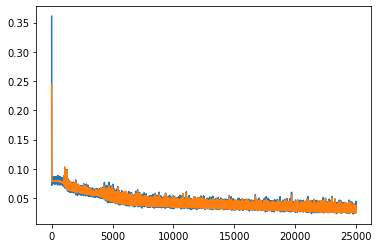

In [ ]:
#saving the cost data and replotting
np.save('b32.npy',np.array([costt32 ,costv32]))
data2=np.load('b32.npy')
plt.plot(data2[0])
plt.plot(data2[1])
plt.show()

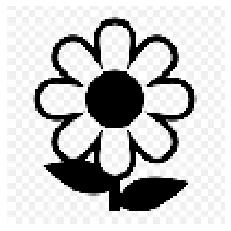

0 0.35338328756847553 0.09939341171573608
50 0.08112033377756021 0.07863756321125119
100 0.07443635518128583 0.07866084582830504
150 0.08021475444419898 0.07839433629450576
200 0.08455118220791678 0.078388090505696
250 0.0802728551421309 0.07796565735344121
300 0.07903861815514805 0.07749214901222536
350 0.08056763206784863 0.0768465530620945
400 0.07303932533050876 0.07590429974544675
450 0.07743196108502286 0.07354170750619653
500 0.07929637796015096 0.07398116226078406
550 0.08292159875997052 0.07666372403401808
600 0.06736976637967373 0.06435055195800117
650 0.06845896647078592 0.06715491728906663
700 0.0651769594206404 0.06609036917376535
750 0.07236147846777663 0.065912935663555
800 0.06783941381027951 0.06885430248418559
850 0.06971386612700013 0.0710008581736055
900 0.06452180120191764 0.062465185169033606
950 0.06685808694854592 0.06364746184685216
1000 0.06268717944330669 0.06121210848317404
1050 0.06573284804217781 0.061726283703259034
1100 0.06342098181084374 0.061294467821

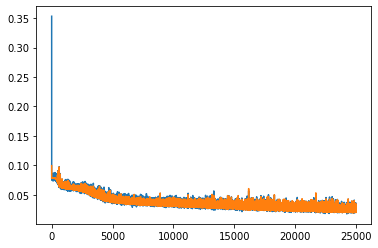

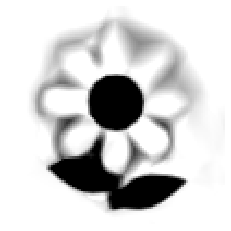

In [ ]:
#64 neurons
#
import numpy as np # for linear algebra
import matplotlib.pyplot as plt # for plotting
import cv2

#Activation function (ReLU)
def y_dydz(z): # calculate sigma(z) and sigma'(z)
     yval=z*(z>0)
     dydz=(z>0)
     return(yval,dydz)

def forward_step(y_in,w,b): # calculate output value of a layer, from input y_in
    z=np.dot(y_in,w)+b # w=weights for synaptic links between layers, b=bias vector for the layer
    #Z is preactivated output
    return(y_dydz(z)) # apply activation function sigma and return output as well as its derivative wrt z

def apply_network(y_in): # One forward propagation through the network
    global Weights, Biases, NLayers
    #NLayers = number of hidden layers + 1 = Number of layers - 1
    global Ylayer, dydz_layer # for storing output from each layer and dy/dz values

    y=y_in
    Ylayer[0]=y #Inputs
    for j in range(NLayers): # loop through all layers, excluding inputlayer
        # j=0 corresponds to the first hidden layer above the input
        y,dydz=forward_step(y,Weights[j],Biases[j]) # one step, into layer j
        dydz_layer[j]=dydz # store sigma'(z), needed later in backprop]
        Ylayer[j+1]=y # store sigma(z), needed later in backprop]
    return(y)

def apply_network_only(y_in): #only one forward pass through the network
    #Same as apply_network() by with no storege of y and dydz
    y=y_in
    for j in range(NLayers):
        y,dydz=forward_step(y,Weights[j],Biases[j])
    return(y)

def backward_step(Delta,w,dy):
    # Delta at layer n, of batchsize x layersize(n))
    # w between n-1 and n [layersize(n-1) x layersize(n) matrix]
    # dy = dy/dz at layer n-1, of batchsize x layersize(n-1)
    return( np.dot(Delta,np.transpose(w))*dy )

def backpropagation(y_true): #one backward pass through the network
    # to calculate dCdW and dCdb and store them
    global Ylayer, dydz_layer, Weights, Biases, NLayers
    global dCdw_layer, dCdb_layer # dCost/dw and dCost/db
    global batchsize

    Delta=(Ylayer[-1]-y_true)*dydz_layer[-1]
    dCdw_layer[-1]=np.dot(np.transpose(Ylayer[-2]),Delta)/batchsize
    dCdb_layer[-1]=np.sum(Delta,axis=0)/batchsize
    for j in range(NLayers-1):
        Delta=backward_step(Delta,Weights[-1-j],dydz_layer[-2-j])
        dCdw_layer[-2-j]=np.dot(np.transpose(Ylayer[-3-j]),Delta)/batchsize
        dCdb_layer[-2-j]=np.sum(Delta,axis=0)/batchsize


####Gradient descent
def gradient_descent(eta): # update weights & biases (after backpropagation)
    global dCdw_layer, dCdb_layer, Weights, Biases
    ##eta is learning rate or step parameter
    for j in range(NLayers):
        Weights[j]-=eta*dCdw_layer[j]
        Biases[j]-=eta*dCdb_layer[j]

def train_one_step(y_in,y_true,eta): # one full training of a batch
    # y_in is an array of size batchsize x number of inputs
    # y_true is an array of size batchsize x number of outputs
    # eta is the stepsize for the gradient descent method
    global y_out

    y_out=apply_network(y_in) #Ylayer, dydz are calculated and stored
    backpropagation(y_true) #dCdw and dCdb are calculated and stored
    gradient_descent(eta)
    cost=0.5*(np.sum((y_true-y_out)**2))/batchsize
    return(cost)

def Validation(y_in,y_true,nvalid): # one full training of a batch
    # y_in is an array of size batchsize x number of inputs
    # y_true is an array of size batchsize x number of outputs
    y_out=apply_network_only(y_in) #Ylayer, dydz are calculated and stored
    cost=0.5*(np.sum((y_true-y_out)**2))/nvalid
    return(cost)

# set up all the layers with neurons
LayerSizes=[2,64,64,64,1] # input,hidden1,hidden2,...,output
NLayers=int(len(LayerSizes)-1) # does not count the input-layer (but does count the output-layer)

# Initialize the weights and biases
Weights=[np.random.uniform(low=-0.1,high=+0.1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NLayers)]
Biases=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]

# set up all the storge lists
Ylayer=[np.zeros(LayerSizes[j]) for j in range(NLayers+1)]
dydz_layer=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]
dCdw_layer=[np.zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NLayers)]
dCdb_layer=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]

#from PIL import Image
# load the pixel image!
pics=cv2.imread('emoji7.png')
pixel_image=np.transpose(pics[:,:,0]) # have to transpose...
pixel_image=pixel_image[:,::-1] # and flip... to get the right view!
pixel_image-=np.min(pixel_image)
pixel_image=(pixel_image.astype(dtype='float'))/pixel_image.max() # normalize between 0 and 1!
Npixels=np.shape(pixel_image)[0] # assuming a square image!

# the function we want to have (desired outcome)
def CustomFunc(x0,x1):
    global pixel_image, Npixels
    # convert to integer coordinates (assuming input is 0..1)
    x0int=(x0*Npixels*0.99999).astype(dtype='int')
    x1int=(x1*Npixels*0.99999).astype(dtype='int')
    return(pixel_image[x0int,x1int]) # extract color values at these pixels

# check that this works:
Npixels_Test=100 # do the test output on a low-res grid! (saves time)
xrange=np.linspace(0,1,Npixels_Test)
x0,x1=np.meshgrid(xrange,xrange)
plt.imshow(CustomFunc(x0,x1), cmap='gray', interpolation='nearest',origin='lower')
plt.axis('off')
#plt.colorbar()
plt.show()

######################################################################################
batchsize=1500
def make_train_batch(): #random postions in a 2D square
    global batchsize

    inputs=np.random.uniform(low=0,high=1,size=[batchsize,2])
    Trueval=np.zeros([batchsize,1]) # must have right dimensions
    Trueval[:,0]=CustomFunc(inputs[:,0],inputs[:,1])
    return(inputs,Trueval)

nvalid=3000
def make_valid_batch(nvalid): #random postions in a 2D square for validation
    inputs=np.random.uniform(low=0,high=1,size=[nvalid,2])
    Trueval=np.zeros([nvalid,1]) # Careful about right dimensions
    Trueval[:,0]=CustomFunc(inputs[:,0],inputs[:,1])
    return(inputs,Trueval)

#Training the Neural network in nsteps
eta=0.75 #learning rate
nsteps=25000
costt64=np.zeros(nsteps) #for training samples
costv64=np.zeros(nsteps) #for validation samples

valid_inp,valid_out=make_valid_batch(nvalid)
best=100.0
for k in range(nsteps):
    train_inp,train_out=make_train_batch()
    costt64[k]=train_one_step(train_inp,train_out,eta)
    costv64[k]=Validation(valid_inp,valid_out,nvalid)
    if k%50 == 0:
      print(k,costt64[k],costv64[k])
    if costv64[k] < best: ##store the wights/biases for the best model
        best=costv64[k]
        SWeights=Weights
        SBiases=Biases
#        print(k,costt64[k],costv64[k])

plt.plot(costt64)
plt.plot(costv64)
plt.show()

###################################################################
#Use the best model for testing
Weights=SWeights
Biases=SBiases

# Testing the model
#In this case test batch includes all the points on the image grid 50x50
test_batchsize=np.shape(x0)[0]*np.shape(x0)[1]
testsample=np.zeros([test_batchsize,2])
testsample[:,0]=np.ndarray.flatten(x0)
testsample[:,1]=np.ndarray.flatten(x1)
# check the output of this net
testoutput=apply_network_only(testsample)
# show this!
myim=plt.imshow(np.reshape(testoutput,np.shape(x0)), cmap='gray', origin='lower',interpolation='nearest',vmin=0.0,vmax=1.0)
plt.axis('off')
#plt.colorbar()
plt.show()

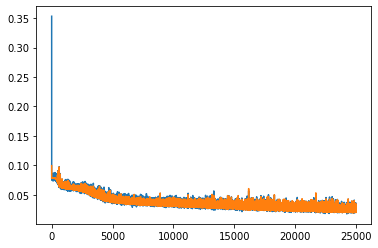

In [ ]:
#saving the cost data and replotting
np.save('b64.npy',np.array([costt64,costv64]))
data3=np.load('b64.npy')
plt.plot(data3[0])
plt.plot(data3[1])
plt.show()

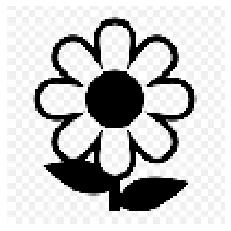

0 0.349909925091931 0.08170913066523783
50 0.07804766114224385 0.0755807254099464
100 0.07888788702889585 0.07510764200566344
150 0.08022013260534692 0.07414502943423273
200 0.07668104220330559 0.07368012474364366
250 0.07169637233642241 0.06925427364506127
300 0.0773003095667356 0.06769906796917248
350 0.06630036965365084 0.06546519177539803
400 0.07417358145869209 0.06876407968447061
450 0.07732699161259707 0.07138854463166416
500 0.06672046257531306 0.06201523216068347
550 0.07182083688971962 0.06823189947993567
600 0.06357421905464661 0.06120067977117924
650 0.06412607834568994 0.0627649748169014
700 0.06939920961784828 0.06294874159911713
750 0.06992683450811085 0.06352701193473818
800 0.06546254961210277 0.060663350395259455
850 0.061550691094466536 0.06034487662864768
900 0.0615832984492312 0.06024742256564663
950 0.06552034691735822 0.06101775756899593
1000 0.0629701108489725 0.05946363737922274
1050 0.061381140233059385 0.06200687677437808
1100 0.06121700749447815 0.0601228312

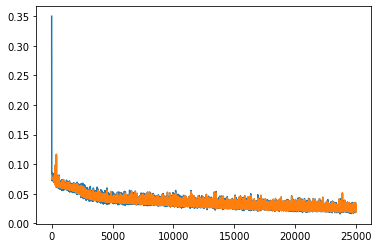

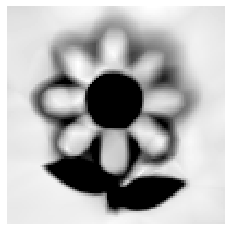

In [ ]:
#128 neurons
import numpy as np # for linear algebra
import matplotlib.pyplot as plt # for plotting
import cv2

#Activation function (ReLU)
def y_dydz(z): # calculate sigma(z) and sigma'(z)
     yval=z*(z>0)
     dydz=(z>0)
     return(yval,dydz)

def forward_step(y_in,w,b): # calculate output value of a layer, from input y_in
    z=np.dot(y_in,w)+b # w=weights for synaptic links between layers, b=bias vector for the layer
    #Z is preactivated output
    return(y_dydz(z)) # apply activation function sigma and return output as well as its derivative wrt z

def apply_network(y_in): # One forward propagation through the network
    global Weights, Biases, NLayers
    #NLayers = number of hidden layers + 1 = Number of layers - 1
    global Ylayer, dydz_layer # for storing output from each layer and dy/dz values

    y=y_in
    Ylayer[0]=y #Inputs
    for j in range(NLayers): # loop through all layers, excluding inputlayer
        # j=0 corresponds to the first hidden layer above the input
        y,dydz=forward_step(y,Weights[j],Biases[j]) # one step, into layer j
        dydz_layer[j]=dydz # store sigma'(z), needed later in backprop]
        Ylayer[j+1]=y # store sigma(z), needed later in backprop]
    return(y)

def apply_network_only(y_in): #only one forward pass through the network
    #Same as apply_network() by with no storege of y and dydz
    y=y_in
    for j in range(NLayers):
        y,dydz=forward_step(y,Weights[j],Biases[j])
    return(y)

def backward_step(Delta,w,dy):
    # Delta at layer n, of batchsize x layersize(n))
    # w between n-1 and n [layersize(n-1) x layersize(n) matrix]
    # dy = dy/dz at layer n-1, of batchsize x layersize(n-1)
    return( np.dot(Delta,np.transpose(w))*dy )

def backpropagation(y_true): #one backward pass through the network
    # to calculate dCdW and dCdb and store them
    global Ylayer, dydz_layer, Weights, Biases, NLayers
    global dCdw_layer, dCdb_layer # dCost/dw and dCost/db
    global batchsize

    Delta=(Ylayer[-1]-y_true)*dydz_layer[-1]
    dCdw_layer[-1]=np.dot(np.transpose(Ylayer[-2]),Delta)/batchsize
    dCdb_layer[-1]=np.sum(Delta,axis=0)/batchsize
    for j in range(NLayers-1):
        Delta=backward_step(Delta,Weights[-1-j],dydz_layer[-2-j])
        dCdw_layer[-2-j]=np.dot(np.transpose(Ylayer[-3-j]),Delta)/batchsize
        dCdb_layer[-2-j]=np.sum(Delta,axis=0)/batchsize


####Gradient descent
def gradient_descent(eta): # update weights & biases (after backpropagation)
    global dCdw_layer, dCdb_layer, Weights, Biases
    ##eta is learning rate or step parameter
    for j in range(NLayers):
        Weights[j]-=eta*dCdw_layer[j]
        Biases[j]-=eta*dCdb_layer[j]

def train_one_step(y_in,y_true,eta): # one full training of a batch
    # y_in is an array of size batchsize x number of inputs
    # y_true is an array of size batchsize x number of outputs
    # eta is the stepsize for the gradient descent method
    global y_out

    y_out=apply_network(y_in) #Ylayer, dydz are calculated and stored
    backpropagation(y_true) #dCdw and dCdb are calculated and stored
    gradient_descent(eta)
    cost=0.5*(np.sum((y_true-y_out)**2))/batchsize
    return(cost)

def Validation(y_in,y_true,nvalid): # one full training of a batch
    # y_in is an array of size batchsize x number of inputs
    # y_true is an array of size batchsize x number of outputs
    y_out=apply_network_only(y_in) #Ylayer, dydz are calculated and stored
    cost=0.5*(np.sum((y_true-y_out)**2))/nvalid
    return(cost)

# set up all the layers with neurons
LayerSizes=[2,128,128,128,1] # input,hidden1,hidden2,...,output
NLayers=int(len(LayerSizes)-1) # does not count the input-layer (but does count the output-layer)

# Initialize the weights and biases
Weights=[np.random.uniform(low=-0.1,high=+0.1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NLayers)]
Biases=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]

# set up all the storge lists
Ylayer=[np.zeros(LayerSizes[j]) for j in range(NLayers+1)]
dydz_layer=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]
dCdw_layer=[np.zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NLayers)]
dCdb_layer=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]

#from PIL import Image
# load the pixel image!
pics=cv2.imread('emoji7.png')
pixel_image=np.transpose(pics[:,:,0]) # have to transpose...
pixel_image=pixel_image[:,::-1] # and flip... to get the right view!
pixel_image-=np.min(pixel_image)
pixel_image=(pixel_image.astype(dtype='float'))/pixel_image.max() # normalize between 0 and 1!
Npixels=np.shape(pixel_image)[0] # assuming a square image!

# the function we want to have (desired outcome)
def CustomFunc(x0,x1):
    global pixel_image, Npixels
    # convert to integer coordinates (assuming input is 0..1)
    x0int=(x0*Npixels*0.99999).astype(dtype='int')
    x1int=(x1*Npixels*0.99999).astype(dtype='int')
    return(pixel_image[x0int,x1int]) # extract color values at these pixels

# check that this works:
Npixels_Test=100 # do the test output on a low-res grid! (saves time)
xrange=np.linspace(0,1,Npixels_Test)
x0,x1=np.meshgrid(xrange,xrange)
plt.imshow(CustomFunc(x0,x1), cmap='gray', interpolation='nearest',origin='lower')
plt.axis('off')
#plt.colorbar()
plt.show()

######################################################################################
batchsize=1500
def make_train_batch(): #random postions in a 2D square
    global batchsize

    inputs=np.random.uniform(low=0,high=1,size=[batchsize,2])
    Trueval=np.zeros([batchsize,1]) # must have right dimensions
    Trueval[:,0]=CustomFunc(inputs[:,0],inputs[:,1])
    return(inputs,Trueval)

nvalid=3000
def make_valid_batch(nvalid): #random postions in a 2D square for validation
    inputs=np.random.uniform(low=0,high=1,size=[nvalid,2])
    Trueval=np.zeros([nvalid,1]) # Careful about right dimensions
    Trueval[:,0]=CustomFunc(inputs[:,0],inputs[:,1])
    return(inputs,Trueval)

#Training the Neural network in nsteps
eta=0.75 #learning rate
nsteps=25000
costt128=np.zeros(nsteps) #for training samples
costv128=np.zeros(nsteps) #for validation samples

valid_inp,valid_out=make_valid_batch(nvalid)
best=100.0
for k in range(nsteps):
    train_inp,train_out=make_train_batch()
    costt128[k]=train_one_step(train_inp,train_out,eta)
    costv128[k]=Validation(valid_inp,valid_out,nvalid)
    if k%50 == 0:
      print(k,costt128[k],costv128[k])
    if costv128[k] < best: ##store the wights/biases for the best model
        best=costv128[k]
        SWeights=Weights
        SBiases=Biases
#        print(k,costt128[k],costv128[k])

plt.plot(costt128)
plt.plot(costv128)
plt.show()

###################################################################
#Use the best model for testing
Weights=SWeights
Biases=SBiases

# Testing the model
#In this case test batch includes all the points on the image grid 50x50
test_batchsize=np.shape(x0)[0]*np.shape(x0)[1]
testsample=np.zeros([test_batchsize,2])
testsample[:,0]=np.ndarray.flatten(x0)
testsample[:,1]=np.ndarray.flatten(x1)
# check the output of this net
testoutput=apply_network_only(testsample)
# show this!
myim=plt.imshow(np.reshape(testoutput,np.shape(x0)), cmap='gray', origin='lower',interpolation='nearest',vmin=0.0,vmax=1.0)
plt.axis('off')
#plt.colorbar()
plt.show()

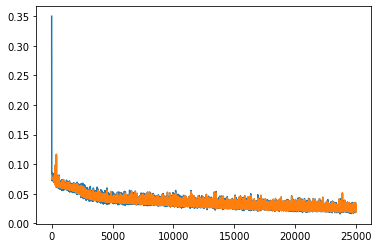

In [ ]:
#saving the cost data and replotting
np.save('b128.npy',np.array([costt128,costv128]))
data4=np.load('b128.npy')
plt.plot(data4[0])
plt.plot(data4[1])
plt.show()

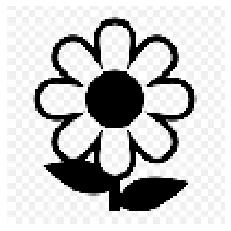

0 0.35513444545623507 0.08011379283027162
50 0.07500721178793252 0.07809646574489384
100 0.07565378875925365 0.07716243680563772
150 0.07684283429829376 0.07520090740045426
200 0.07999896816621312 0.07936160463270202
250 0.08121077234863698 0.07649386449847016
300 0.07563941508843974 0.07536063367730239
350 0.07224100985704132 0.07031338460410685
400 0.0716726840604335 0.06996532948036886
450 0.06663515070968642 0.06690990718062657
500 0.06194949165332765 0.06202278201652445
550 0.06788751041520603 0.06788372291165315
600 0.06460916546410456 0.06152254153896108
650 0.06228374840247136 0.06233751540188117
700 0.0689555195248326 0.06599493676704545
750 0.06478342699144203 0.06552105792211511
800 0.06806279113642091 0.06336287407122165
850 0.06149868982317586 0.06277170585570442
900 0.06378734356701904 0.06197306994116451
950 0.06429978513435294 0.06203818305419164
1000 0.06383356639712082 0.061917995934649646
1050 0.05751946271220794 0.05919275108538425
1100 0.060330563021597734 0.058745

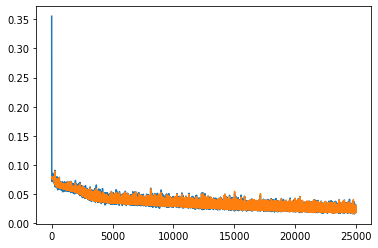

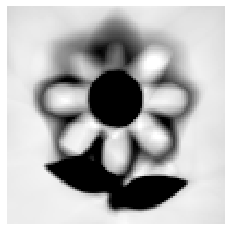

In [ ]:
#160 neurons
import numpy as np # for linear algebra
import matplotlib.pyplot as plt # for plotting
import cv2

#Activation function (ReLU)
def y_dydz(z): # calculate sigma(z) and sigma'(z)
     yval=z*(z>0)
     dydz=(z>0)
     return(yval,dydz)

def forward_step(y_in,w,b): # calculate output value of a layer, from input y_in
    z=np.dot(y_in,w)+b # w=weights for synaptic links between layers, b=bias vector for the layer
    #Z is preactivated output
    return(y_dydz(z)) # apply activation function sigma and return output as well as its derivative wrt z

def apply_network(y_in): # One forward propagation through the network
    global Weights, Biases, NLayers
    #NLayers = number of hidden layers + 1 = Number of layers - 1
    global Ylayer, dydz_layer # for storing output from each layer and dy/dz values

    y=y_in
    Ylayer[0]=y #Inputs
    for j in range(NLayers): # loop through all layers, excluding inputlayer
        # j=0 corresponds to the first hidden layer above the input
        y,dydz=forward_step(y,Weights[j],Biases[j]) # one step, into layer j
        dydz_layer[j]=dydz # store sigma'(z), needed later in backprop]
        Ylayer[j+1]=y # store sigma(z), needed later in backprop]
    return(y)

def apply_network_only(y_in): #only one forward pass through the network
    #Same as apply_network() by with no storege of y and dydz
    y=y_in
    for j in range(NLayers):
        y,dydz=forward_step(y,Weights[j],Biases[j])
    return(y)

def backward_step(Delta,w,dy):
    # Delta at layer n, of batchsize x layersize(n))
    # w between n-1 and n [layersize(n-1) x layersize(n) matrix]
    # dy = dy/dz at layer n-1, of batchsize x layersize(n-1)
    return( np.dot(Delta,np.transpose(w))*dy )

def backpropagation(y_true): #one backward pass through the network
    # to calculate dCdW and dCdb and store them
    global Ylayer, dydz_layer, Weights, Biases, NLayers
    global dCdw_layer, dCdb_layer # dCost/dw and dCost/db
    global batchsize

    Delta=(Ylayer[-1]-y_true)*dydz_layer[-1]
    dCdw_layer[-1]=np.dot(np.transpose(Ylayer[-2]),Delta)/batchsize
    dCdb_layer[-1]=np.sum(Delta,axis=0)/batchsize
    for j in range(NLayers-1):
        Delta=backward_step(Delta,Weights[-1-j],dydz_layer[-2-j])
        dCdw_layer[-2-j]=np.dot(np.transpose(Ylayer[-3-j]),Delta)/batchsize
        dCdb_layer[-2-j]=np.sum(Delta,axis=0)/batchsize


####Gradient descent
def gradient_descent(eta): # update weights & biases (after backpropagation)
    global dCdw_layer, dCdb_layer, Weights, Biases
    ##eta is learning rate or step parameter
    for j in range(NLayers):
        Weights[j]-=eta*dCdw_layer[j]
        Biases[j]-=eta*dCdb_layer[j]

def train_one_step(y_in,y_true,eta): # one full training of a batch
    # y_in is an array of size batchsize x number of inputs
    # y_true is an array of size batchsize x number of outputs
    # eta is the stepsize for the gradient descent method
    global y_out

    y_out=apply_network(y_in) #Ylayer, dydz are calculated and stored
    backpropagation(y_true) #dCdw and dCdb are calculated and stored
    gradient_descent(eta)
    cost=0.5*(np.sum((y_true-y_out)**2))/batchsize
    return(cost)

def Validation(y_in,y_true,nvalid): # one full training of a batch
    # y_in is an array of size batchsize x number of inputs
    # y_true is an array of size batchsize x number of outputs
    y_out=apply_network_only(y_in) #Ylayer, dydz are calculated and stored
    cost=0.5*(np.sum((y_true-y_out)**2))/nvalid
    return(cost)

# set up all the layers with neurons
LayerSizes=[2,160,160,160,1] # input,hidden1,hidden2,...,output
NLayers=int(len(LayerSizes)-1) # does not count the input-layer (but does count the output-layer)

# Initialize the weights and biases
Weights=[np.random.uniform(low=-0.1,high=+0.1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NLayers)]
Biases=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]

# set up all the storge lists
Ylayer=[np.zeros(LayerSizes[j]) for j in range(NLayers+1)]
dydz_layer=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]
dCdw_layer=[np.zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NLayers)]
dCdb_layer=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]

#from PIL import Image
# load the pixel image!
pics=cv2.imread('emoji7.png')
pixel_image=np.transpose(pics[:,:,0]) # have to transpose...
pixel_image=pixel_image[:,::-1] # and flip... to get the right view!
pixel_image-=np.min(pixel_image)
pixel_image=(pixel_image.astype(dtype='float'))/pixel_image.max() # normalize between 0 and 1!
Npixels=np.shape(pixel_image)[0] # assuming a square image!

# the function we want to have (desired outcome)
def CustomFunc(x0,x1):
    global pixel_image, Npixels
    # convert to integer coordinates (assuming input is 0..1)
    x0int=(x0*Npixels*0.99999).astype(dtype='int')
    x1int=(x1*Npixels*0.99999).astype(dtype='int')
    return(pixel_image[x0int,x1int]) # extract color values at these pixels

# check that this works:
Npixels_Test=100 # do the test output on a low-res grid! (saves time)
xrange=np.linspace(0,1,Npixels_Test)
x0,x1=np.meshgrid(xrange,xrange)
plt.imshow(CustomFunc(x0,x1), cmap='gray', interpolation='nearest',origin='lower')
plt.axis('off')
#plt.colorbar()
plt.show()

######################################################################################
batchsize=1500
def make_train_batch(): #random postions in a 2D square
    global batchsize

    inputs=np.random.uniform(low=0,high=1,size=[batchsize,2])
    Trueval=np.zeros([batchsize,1]) # must have right dimensions
    Trueval[:,0]=CustomFunc(inputs[:,0],inputs[:,1])
    return(inputs,Trueval)

nvalid=3000
def make_valid_batch(nvalid): #random postions in a 2D square for validation
    inputs=np.random.uniform(low=0,high=1,size=[nvalid,2])
    Trueval=np.zeros([nvalid,1]) # Careful about right dimensions
    Trueval[:,0]=CustomFunc(inputs[:,0],inputs[:,1])
    return(inputs,Trueval)

#Training the Neural network in nsteps
eta=0.75 #learning rate
nsteps=25000
costt160=np.zeros(nsteps) #for training samples
costv160=np.zeros(nsteps) #for validation samples

valid_inp,valid_out=make_valid_batch(nvalid)
best=100.0
for k in range(nsteps):
    train_inp,train_out=make_train_batch()
    costt160[k]=train_one_step(train_inp,train_out,eta)
    costv160[k]=Validation(valid_inp,valid_out,nvalid)
    if k%50 == 0:
      print(k,costt160[k],costv160[k])
    if costv160[k] < best: ##store the wights/biases for the best model
        best=costv160[k]
        SWeights=Weights
        SBiases=Biases
#        print(k,costt160[k],costv160[k])

plt.plot(costt160)
plt.plot(costv160)
plt.show()

###################################################################
#Use the best model for testing
Weights=SWeights
Biases=SBiases

# Testing the model
#In this case test batch includes all the points on the image grid 50x50
test_batchsize=np.shape(x0)[0]*np.shape(x0)[1]
testsample=np.zeros([test_batchsize,2])
testsample[:,0]=np.ndarray.flatten(x0)
testsample[:,1]=np.ndarray.flatten(x1)
# check the output of this net
testoutput=apply_network_only(testsample)
# show this!
myim=plt.imshow(np.reshape(testoutput,np.shape(x0)), cmap='gray', origin='lower',interpolation='nearest',vmin=0.0,vmax=1.0)
plt.axis('off')
#plt.colorbar()
plt.show()

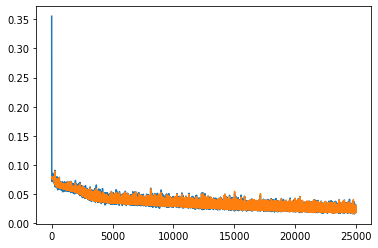

In [ ]:
#saving the cost data and replotting
np.save('b160.npy',np.array([costt160,costv160]))
data5=np.load('b160.npy')
plt.plot(data5[0])
plt.plot(data5[1])
plt.show()

# COMPARING LEARNING CURVES WITH VARYING NUMBER OF NEURONS




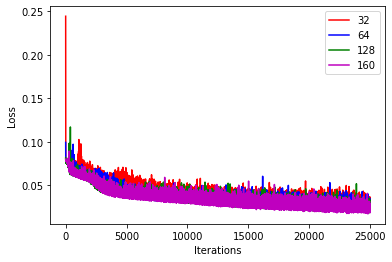

In [ ]:
#comparing learning rates

import matplotlib.pyplot as plt

plt.plot(data2[1], "-r", label="32")
plt.plot(data3[1], "-b", label="64")
plt.plot(data4[1], "-g", label="128")
plt.plot(data5[1], "-m", label="160")

plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.legend(loc="upper right")

plt.show()

# INFERENCE MADE

from the above diagram it is observed that as the number of neurons increase the NN predicts the given image more accurately.
Here,The NN with 160 neurons predicts the given emoji most accurately.The loss of information is pretty low with this network whereas the network with 32 neurons poorly predicts the image.


# PART C
with learning rates
A) 0.2

B) 0.8

C)1.5

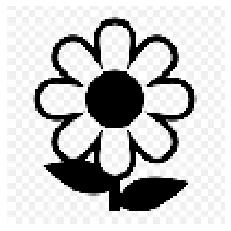

0 0.35477795165438847 0.3259428703361993
50 0.0763273753607896 0.07933509239455379
100 0.07952940193949767 0.07925653608908755
150 0.0820305588381142 0.07921269853086162
200 0.07871026272911168 0.07913370478817269
250 0.0812704601773987 0.0790700063847024
300 0.08441475468368255 0.07900484350656767
350 0.08114981520045678 0.07894056669139597
400 0.07967939307065233 0.07884152372658214
450 0.0796199842592886 0.0787528939152559
500 0.07687603055216828 0.07865378174694851
550 0.08159206703859435 0.07854658112407492
600 0.0864190354852898 0.07846860036379576
650 0.07961402183389261 0.07826916454949238
700 0.07997372461946313 0.07813043939385085
750 0.07786969010836887 0.07791654319754246
800 0.07723968970810974 0.07768310380764126
850 0.0787102253823662 0.0774565960354067
900 0.0751425001651806 0.07719093230982066
950 0.07181400643335685 0.076932232719564
1000 0.07901143918993825 0.0765157797081775
1050 0.0776316610962088 0.07606541428852558
1100 0.08013276705754202 0.0756828602534265
1150

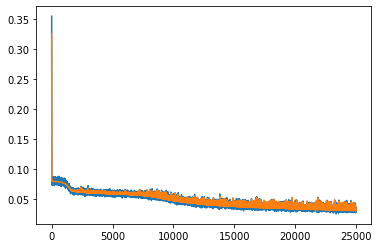

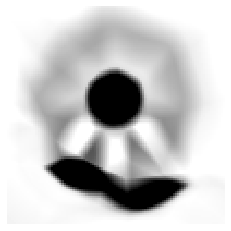

In [ ]:
#c
#learning rate 0.2
import numpy as np # for linear algebra
import matplotlib.pyplot as plt # for plotting
import cv2

#Activation function (ReLU)
def y_dydz(z): # calculate sigma(z) and sigma'(z)
     yval=z*(z>0)
     dydz=(z>0)
     return(yval,dydz)

def forward_step(y_in,w,b): # calculate output value of a layer, from input y_in
    z=np.dot(y_in,w)+b # w=weights for synaptic links between layers, b=bias vector for the layer
    #Z is preactivated output
    return(y_dydz(z)) # apply activation function sigma and return output as well as its derivative wrt z

def apply_network(y_in): # One forward propagation through the network
    global Weights, Biases, NLayers
    #NLayers = number of hidden layers + 1 = Number of layers - 1
    global Ylayer, dydz_layer # for storing output from each layer and dy/dz values

    y=y_in
    Ylayer[0]=y #Inputs
    for j in range(NLayers): # loop through all layers, excluding inputlayer
        # j=0 corresponds to the first hidden layer above the input
        y,dydz=forward_step(y,Weights[j],Biases[j]) # one step, into layer j
        dydz_layer[j]=dydz # store sigma'(z), needed later in backprop]
        Ylayer[j+1]=y # store sigma(z), needed later in backprop]
    return(y)

def apply_network_only(y_in): #only one forward pass through the network
    #Same as apply_network() by with no storege of y and dydz
    y=y_in
    for j in range(NLayers):
        y,dydz=forward_step(y,Weights[j],Biases[j])
    return(y)

def backward_step(Delta,w,dy):
    # Delta at layer n, of batchsize x layersize(n))
    # w between n-1 and n [layersize(n-1) x layersize(n) matrix]
    # dy = dy/dz at layer n-1, of batchsize x layersize(n-1)
    return( np.dot(Delta,np.transpose(w))*dy )

def backpropagation(y_true): #one backward pass through the network
    # to calculate dCdW and dCdb and store them
    global Ylayer, dydz_layer, Weights, Biases, NLayers
    global dCdw_layer, dCdb_layer # dCost/dw and dCost/db
    global batchsize

    Delta=(Ylayer[-1]-y_true)*dydz_layer[-1]
    dCdw_layer[-1]=np.dot(np.transpose(Ylayer[-2]),Delta)/batchsize
    dCdb_layer[-1]=np.sum(Delta,axis=0)/batchsize
    for j in range(NLayers-1):
        Delta=backward_step(Delta,Weights[-1-j],dydz_layer[-2-j])
        dCdw_layer[-2-j]=np.dot(np.transpose(Ylayer[-3-j]),Delta)/batchsize
        dCdb_layer[-2-j]=np.sum(Delta,axis=0)/batchsize


####Gradient descent
def gradient_descent(eta): # update weights & biases (after backpropagation)
    global dCdw_layer, dCdb_layer, Weights, Biases
    ##eta is learning rate or step parameter
    for j in range(NLayers):
        Weights[j]-=eta*dCdw_layer[j]
        Biases[j]-=eta*dCdb_layer[j]

def train_one_step(y_in,y_true,eta): # one full training of a batch
    # y_in is an array of size batchsize x number of inputs
    # y_true is an array of size batchsize x number of outputs
    # eta is the stepsize for the gradient descent method
    global y_out

    y_out=apply_network(y_in) #Ylayer, dydz are calculated and stored
    backpropagation(y_true) #dCdw and dCdb are calculated and stored
    gradient_descent(eta)
    cost=0.5*(np.sum((y_true-y_out)**2))/batchsize
    return(cost)

def Validation(y_in,y_true,nvalid): # one full training of a batch
    # y_in is an array of size batchsize x number of inputs
    # y_true is an array of size batchsize x number of outputs
    y_out=apply_network_only(y_in) #Ylayer, dydz are calculated and stored
    cost=0.5*(np.sum((y_true-y_out)**2))/nvalid
    return(cost)

# set up all the layers with neurons
LayerSizes=[2,100,100,100,1] # input,hidden1,hidden2,...,output
NLayers=int(len(LayerSizes)-1) # does not count the input-layer (but does count the output-layer)

# Initialize the weights and biases
Weights=[np.random.uniform(low=-0.1,high=+0.1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NLayers)]
Biases=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]

# set up all the storge lists
Ylayer=[np.zeros(LayerSizes[j]) for j in range(NLayers+1)]
dydz_layer=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]
dCdw_layer=[np.zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NLayers)]
dCdb_layer=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]

#from PIL import Image
# load the pixel image!
pics=cv2.imread('emoji7.png')
pixel_image=np.transpose(pics[:,:,0]) # have to transpose...
pixel_image=pixel_image[:,::-1] # and flip... to get the right view!
pixel_image-=np.min(pixel_image)
pixel_image=(pixel_image.astype(dtype='float'))/pixel_image.max() # normalize between 0 and 1!
Npixels=np.shape(pixel_image)[0] # assuming a square image!

# the function we want to have (desired outcome)
def CustomFunc(x0,x1):
    global pixel_image, Npixels
    # convert to integer coordinates (assuming input is 0..1)
    x0int=(x0*Npixels*0.99999).astype(dtype='int')
    x1int=(x1*Npixels*0.99999).astype(dtype='int')
    return(pixel_image[x0int,x1int]) # extract color values at these pixels

# check that this works:
Npixels_Test=100 # do the test output on a low-res grid! (saves time)
xrange=np.linspace(0,1,Npixels_Test)
x0,x1=np.meshgrid(xrange,xrange)
plt.imshow(CustomFunc(x0,x1), cmap='gray', interpolation='nearest',origin='lower')
plt.axis('off')
#plt.colorbar()
plt.show()

######################################################################################
batchsize=1500
def make_train_batch(): #random postions in a 2D square
    global batchsize

    inputs=np.random.uniform(low=0,high=1,size=[batchsize,2])
    Trueval=np.zeros([batchsize,1]) # must have right dimensions
    Trueval[:,0]=CustomFunc(inputs[:,0],inputs[:,1])
    return(inputs,Trueval)

nvalid=3000
def make_valid_batch(nvalid): #random postions in a 2D square for validation
    inputs=np.random.uniform(low=0,high=1,size=[nvalid,2])
    Trueval=np.zeros([nvalid,1]) # Careful about right dimensions
    Trueval[:,0]=CustomFunc(inputs[:,0],inputs[:,1])
    return(inputs,Trueval)

#Training the Neural network in nsteps
eta=0.2 #learning rate
nsteps=25000
costtc1=np.zeros(nsteps) #for training samples
costvc1=np.zeros(nsteps) #for validation samples

valid_inp,valid_out=make_valid_batch(nvalid)
best=100.0
for k in range(nsteps):
    train_inp,train_out=make_train_batch()
    costtc1[k]=train_one_step(train_inp,train_out,eta)
    costvc1[k]=Validation(valid_inp,valid_out,nvalid)
    if k%50 == 0:
      print(k,costtc1[k],costvc1[k])
    if costvc1[k] < best: ##store the wights/biases for the best model
        best=costvc1[k]
        SWeights=Weights
        SBiases=Biases
#        print(k,costtc1[k],costvc1[k])

plt.plot(costtc1)
plt.plot(costvc1)
plt.show()

###################################################################
#Use the best model for testing
Weights=SWeights
Biases=SBiases

# Testing the model
#In this case test batch includes all the points on the image grid 50x50
test_batchsize=np.shape(x0)[0]*np.shape(x0)[1]
testsample=np.zeros([test_batchsize,2])
testsample[:,0]=np.ndarray.flatten(x0)
testsample[:,1]=np.ndarray.flatten(x1)
# check the output of this net
testoutput=apply_network_only(testsample)
# show this!
myim=plt.imshow(np.reshape(testoutput,np.shape(x0)), cmap='gray', origin='lower',interpolation='nearest',vmin=0.0,vmax=1.0)
plt.axis('off')
#plt.colorbar()
plt.show()

In [ ]:
#saving cost data and plotting
np.save('c1.npy',np.array([costtc1,costvc1]))
data6=np.load("c1.npy")
plt.plot(data6[0])
plt.plot(data6[1])
plt.show()

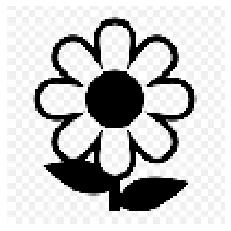

0 0.36767796892778637 0.29058517427241454
50 0.08780958185024944 0.08108979321022258
100 0.08312679159225593 0.08022431660562482
150 0.0796297189118015 0.07946197085433458
200 0.07643629601089735 0.07826677889604844
250 0.07677245561314623 0.07600895670404498
300 0.07537436577191066 0.07999550211369813
350 0.06913775695104883 0.06882213943968425
400 0.06853570967382533 0.06862819659312955
450 0.06463368976334097 0.06454127708142106
500 0.06364226656039444 0.0643889925507041
550 0.06362802049230543 0.06736372682707392
600 0.0646610133622631 0.063326830636396
650 0.0673556009569695 0.06462288389595983
700 0.06656155658785089 0.0632400852244774
750 0.06834095960347986 0.06516483732483709
800 0.07005974694596537 0.06412417725457885
850 0.061938544615356285 0.0641011505991549
900 0.059175919101319155 0.0617776748356681
950 0.06222140806314352 0.06220120341435725
1000 0.060463615137945986 0.06310474992151971
1050 0.06289818995043961 0.06253411955925896
1100 0.06353783373256768 0.062001966359

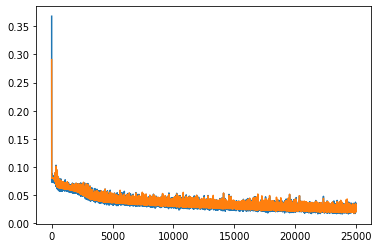

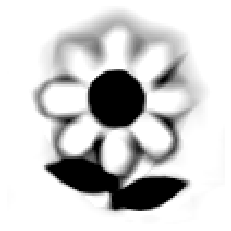

In [ ]:
#0.8 learning rate
import numpy as np # for linear algebra
import matplotlib.pyplot as plt # for plotting
import cv2

#Activation function (ReLU)
def y_dydz(z): # calculate sigma(z) and sigma'(z)
     yval=z*(z>0)
     dydz=(z>0)
     return(yval,dydz)

def forward_step(y_in,w,b): # calculate output value of a layer, from input y_in
    z=np.dot(y_in,w)+b # w=weights for synaptic links between layers, b=bias vector for the layer
    #Z is preactivated output
    return(y_dydz(z)) # apply activation function sigma and return output as well as its derivative wrt z

def apply_network(y_in): # One forward propagation through the network
    global Weights, Biases, NLayers
    #NLayers = number of hidden layers + 1 = Number of layers - 1
    global Ylayer, dydz_layer # for storing output from each layer and dy/dz values

    y=y_in
    Ylayer[0]=y #Inputs
    for j in range(NLayers): # loop through all layers, excluding inputlayer
        # j=0 corresponds to the first hidden layer above the input
        y,dydz=forward_step(y,Weights[j],Biases[j]) # one step, into layer j
        dydz_layer[j]=dydz # store sigma'(z), needed later in backprop]
        Ylayer[j+1]=y # store sigma(z), needed later in backprop]
    return(y)

def apply_network_only(y_in): #only one forward pass through the network
    #Same as apply_network() by with no storege of y and dydz
    y=y_in
    for j in range(NLayers):
        y,dydz=forward_step(y,Weights[j],Biases[j])
    return(y)

def backward_step(Delta,w,dy):
    # Delta at layer n, of batchsize x layersize(n))
    # w between n-1 and n [layersize(n-1) x layersize(n) matrix]
    # dy = dy/dz at layer n-1, of batchsize x layersize(n-1)
    return( np.dot(Delta,np.transpose(w))*dy )

def backpropagation(y_true): #one backward pass through the network
    # to calculate dCdW and dCdb and store them
    global Ylayer, dydz_layer, Weights, Biases, NLayers
    global dCdw_layer, dCdb_layer # dCost/dw and dCost/db
    global batchsize

    Delta=(Ylayer[-1]-y_true)*dydz_layer[-1]
    dCdw_layer[-1]=np.dot(np.transpose(Ylayer[-2]),Delta)/batchsize
    dCdb_layer[-1]=np.sum(Delta,axis=0)/batchsize
    for j in range(NLayers-1):
        Delta=backward_step(Delta,Weights[-1-j],dydz_layer[-2-j])
        dCdw_layer[-2-j]=np.dot(np.transpose(Ylayer[-3-j]),Delta)/batchsize
        dCdb_layer[-2-j]=np.sum(Delta,axis=0)/batchsize


####Gradient descent
def gradient_descent(eta): # update weights & biases (after backpropagation)
    global dCdw_layer, dCdb_layer, Weights, Biases
    ##eta is learning rate or step parameter
    for j in range(NLayers):
        Weights[j]-=eta*dCdw_layer[j]
        Biases[j]-=eta*dCdb_layer[j]

def train_one_step(y_in,y_true,eta): # one full training of a batch
    # y_in is an array of size batchsize x number of inputs
    # y_true is an array of size batchsize x number of outputs
    # eta is the stepsize for the gradient descent method
    global y_out

    y_out=apply_network(y_in) #Ylayer, dydz are calculated and stored
    backpropagation(y_true) #dCdw and dCdb are calculated and stored
    gradient_descent(eta)
    cost=0.5*(np.sum((y_true-y_out)**2))/batchsize
    return(cost)

def Validation(y_in,y_true,nvalid): # one full training of a batch
    # y_in is an array of size batchsize x number of inputs
    # y_true is an array of size batchsize x number of outputs
    y_out=apply_network_only(y_in) #Ylayer, dydz are calculated and stored
    cost=0.5*(np.sum((y_true-y_out)**2))/nvalid
    return(cost)

# set up all the layers with neurons
LayerSizes=[2,100,100,100,1] # input,hidden1,hidden2,...,output
NLayers=int(len(LayerSizes)-1) # does not count the input-layer (but does count the output-layer)

# Initialize the weights and biases
Weights=[np.random.uniform(low=-0.1,high=+0.1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NLayers)]
Biases=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]

# set up all the storge lists
Ylayer=[np.zeros(LayerSizes[j]) for j in range(NLayers+1)]
dydz_layer=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]
dCdw_layer=[np.zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NLayers)]
dCdb_layer=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]

#from PIL import Image
# load the pixel image!
pics=cv2.imread('emoji7.png')
pixel_image=np.transpose(pics[:,:,0]) # have to transpose...
pixel_image=pixel_image[:,::-1] # and flip... to get the right view!
pixel_image-=np.min(pixel_image)
pixel_image=(pixel_image.astype(dtype='float'))/pixel_image.max() # normalize between 0 and 1!
Npixels=np.shape(pixel_image)[0] # assuming a square image!

# the function we want to have (desired outcome)
def CustomFunc(x0,x1):
    global pixel_image, Npixels
    # convert to integer coordinates (assuming input is 0..1)
    x0int=(x0*Npixels*0.99999).astype(dtype='int')
    x1int=(x1*Npixels*0.99999).astype(dtype='int')
    return(pixel_image[x0int,x1int]) # extract color values at these pixels

# check that this works:
Npixels_Test=100 # do the test output on a low-res grid! (saves time)
xrange=np.linspace(0,1,Npixels_Test)
x0,x1=np.meshgrid(xrange,xrange)
plt.imshow(CustomFunc(x0,x1), cmap='gray', interpolation='nearest',origin='lower')
plt.axis('off')
#plt.colorbar()
plt.show()

######################################################################################
batchsize=1500
def make_train_batch(): #random postions in a 2D square
    global batchsize

    inputs=np.random.uniform(low=0,high=1,size=[batchsize,2])
    Trueval=np.zeros([batchsize,1]) # must have right dimensions
    Trueval[:,0]=CustomFunc(inputs[:,0],inputs[:,1])
    return(inputs,Trueval)

nvalid=3000
def make_valid_batch(nvalid): #random postions in a 2D square for validation
    inputs=np.random.uniform(low=0,high=1,size=[nvalid,2])
    Trueval=np.zeros([nvalid,1]) # Careful about right dimensions
    Trueval[:,0]=CustomFunc(inputs[:,0],inputs[:,1])
    return(inputs,Trueval)

#Training the Neural network in nsteps
eta=0.80 #learning rate
nsteps=25000
costtc2=np.zeros(nsteps) #for training samples
costvc2=np.zeros(nsteps) #for validation samples

valid_inp,valid_out=make_valid_batch(nvalid)
best=100.0
for k in range(nsteps):
    train_inp,train_out=make_train_batch()
    costtc2[k]=train_one_step(train_inp,train_out,eta)
    costvc2[k]=Validation(valid_inp,valid_out,nvalid)
    if k%50 == 0:
      print(k,costtc2[k],costvc2[k])
    if costvc2[k] < best: ##store the wights/biases for the best model
        best=costvc2[k]
        SWeights=Weights
        SBiases=Biases
#        print(k,costtc2[k],costvc2[k])

plt.plot(costtc2)
plt.plot(costvc2)
plt.show()

###################################################################
#Use the best model for testing
Weights=SWeights
Biases=SBiases

# Testing the model
#In this case test batch includes all the points on the image grid 50x50
test_batchsize=np.shape(x0)[0]*np.shape(x0)[1]
testsample=np.zeros([test_batchsize,2])
testsample[:,0]=np.ndarray.flatten(x0)
testsample[:,1]=np.ndarray.flatten(x1)
# check the output of this net
testoutput=apply_network_only(testsample)
# show this!
myim=plt.imshow(np.reshape(testoutput,np.shape(x0)), cmap='gray', origin='lower',interpolation='nearest',vmin=0.0,vmax=1.0)
plt.axis('off')
#plt.colorbar()
plt.show()

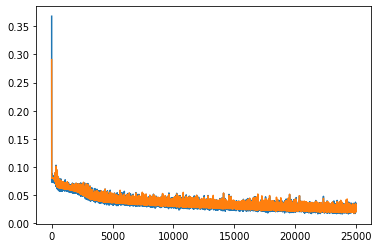

In [ ]:
#saving cost data and plotting
np.save('c2.npy',np.array([costtc2,costvc2]))
data7=np.load("c2.npy")
plt.plot(data7[0])
plt.plot(data7[1])
plt.show()

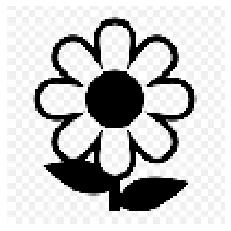

0 0.35505862832986923 0.2162697114775691
50 0.08180066218965945 0.08283878350537609
100 0.08119641951044802 0.08258469187400637
150 0.07809832224297096 0.0823431184197467
200 0.07623727274199892 0.08160295071706496
250 0.09244162240413174 0.08862325464769227
300 0.08074478415415363 0.07727672671477936
350 0.06834544907011363 0.07653599273114375
400 0.10188972612843936 0.09747070209444349
450 0.08437150538307274 0.07220133131006495
500 0.07649868942936185 0.07542035567309821
550 0.06465602675491469 0.06852435178414097
600 0.08114781709687077 0.07643980078290256
650 0.06784774593468099 0.07500973310546587
700 0.06506828602625388 0.06899207709363495
750 0.0929820774551349 0.08728617276871732
800 0.08568224794583972 0.08217670503053418
850 0.08490353178559623 0.08084496508581342
900 0.08194744762013464 0.07373375748977667
950 0.09772190346552229 0.09660599109089923
1000 0.07201918945505387 0.06836318436880437
1050 0.0678666642802944 0.07034975902187532
1100 0.0784199594470222 0.07841352222

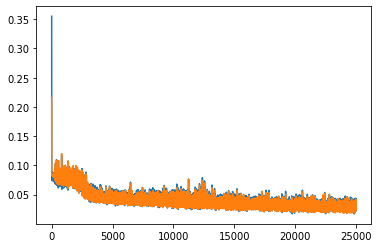

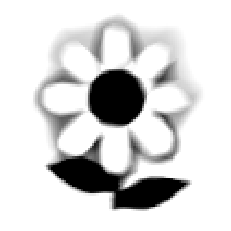

In [ ]:
#1.5 learning rate
import numpy as np # for linear algebra
import matplotlib.pyplot as plt # for plotting
import cv2

#Activation function (ReLU)
def y_dydz(z): # calculate sigma(z) and sigma'(z)
     yval=z*(z>0)
     dydz=(z>0)
     return(yval,dydz)

def forward_step(y_in,w,b): # calculate output value of a layer, from input y_in
    z=np.dot(y_in,w)+b # w=weights for synaptic links between layers, b=bias vector for the layer
    #Z is preactivated output
    return(y_dydz(z)) # apply activation function sigma and return output as well as its derivative wrt z

def apply_network(y_in): # One forward propagation through the network
    global Weights, Biases, NLayers
    #NLayers = number of hidden layers + 1 = Number of layers - 1
    global Ylayer, dydz_layer # for storing output from each layer and dy/dz values

    y=y_in
    Ylayer[0]=y #Inputs
    for j in range(NLayers): # loop through all layers, excluding inputlayer
        # j=0 corresponds to the first hidden layer above the input
        y,dydz=forward_step(y,Weights[j],Biases[j]) # one step, into layer j
        dydz_layer[j]=dydz # store sigma'(z), needed later in backprop]
        Ylayer[j+1]=y # store sigma(z), needed later in backprop]
    return(y)

def apply_network_only(y_in): #only one forward pass through the network
    #Same as apply_network() by with no storege of y and dydz
    y=y_in
    for j in range(NLayers):
        y,dydz=forward_step(y,Weights[j],Biases[j])
    return(y)

def backward_step(Delta,w,dy):
    # Delta at layer n, of batchsize x layersize(n))
    # w between n-1 and n [layersize(n-1) x layersize(n) matrix]
    # dy = dy/dz at layer n-1, of batchsize x layersize(n-1)
    return( np.dot(Delta,np.transpose(w))*dy )

def backpropagation(y_true): #one backward pass through the network
    # to calculate dCdW and dCdb and store them
    global Ylayer, dydz_layer, Weights, Biases, NLayers
    global dCdw_layer, dCdb_layer # dCost/dw and dCost/db
    global batchsize

    Delta=(Ylayer[-1]-y_true)*dydz_layer[-1]
    dCdw_layer[-1]=np.dot(np.transpose(Ylayer[-2]),Delta)/batchsize
    dCdb_layer[-1]=np.sum(Delta,axis=0)/batchsize
    for j in range(NLayers-1):
        Delta=backward_step(Delta,Weights[-1-j],dydz_layer[-2-j])
        dCdw_layer[-2-j]=np.dot(np.transpose(Ylayer[-3-j]),Delta)/batchsize
        dCdb_layer[-2-j]=np.sum(Delta,axis=0)/batchsize


####Gradient descent
def gradient_descent(eta): # update weights & biases (after backpropagation)
    global dCdw_layer, dCdb_layer, Weights, Biases
    ##eta is learning rate or step parameter
    for j in range(NLayers):
        Weights[j]-=eta*dCdw_layer[j]
        Biases[j]-=eta*dCdb_layer[j]

def train_one_step(y_in,y_true,eta): # one full training of a batch
    # y_in is an array of size batchsize x number of inputs
    # y_true is an array of size batchsize x number of outputs
    # eta is the stepsize for the gradient descent method
    global y_out

    y_out=apply_network(y_in) #Ylayer, dydz are calculated and stored
    backpropagation(y_true) #dCdw and dCdb are calculated and stored
    gradient_descent(eta)
    cost=0.5*(np.sum((y_true-y_out)**2))/batchsize
    return(cost)

def Validation(y_in,y_true,nvalid): # one full training of a batch
    # y_in is an array of size batchsize x number of inputs
    # y_true is an array of size batchsize x number of outputs
    y_out=apply_network_only(y_in) #Ylayer, dydz are calculated and stored
    cost=0.5*(np.sum((y_true-y_out)**2))/nvalid
    return(cost)

# set up all the layers with neurons
LayerSizes=[2,100,100,100,1] # input,hidden1,hidden2,...,output
NLayers=int(len(LayerSizes)-1) # does not count the input-layer (but does count the output-layer)

# Initialize the weights and biases
Weights=[np.random.uniform(low=-0.1,high=+0.1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NLayers)]
Biases=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]

# set up all the storge lists
Ylayer=[np.zeros(LayerSizes[j]) for j in range(NLayers+1)]
dydz_layer=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]
dCdw_layer=[np.zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NLayers)]
dCdb_layer=[np.zeros(LayerSizes[j+1]) for j in range(NLayers)]

#from PIL import Image
# load the pixel image!
pics=cv2.imread('emoji7.png')
pixel_image=np.transpose(pics[:,:,0]) # have to transpose...
pixel_image=pixel_image[:,::-1] # and flip... to get the right view!
pixel_image-=np.min(pixel_image)
pixel_image=(pixel_image.astype(dtype='float'))/pixel_image.max() # normalize between 0 and 1!
Npixels=np.shape(pixel_image)[0] # assuming a square image!

# the function we want to have (desired outcome)
def CustomFunc(x0,x1):
    global pixel_image, Npixels
    # convert to integer coordinates (assuming input is 0..1)
    x0int=(x0*Npixels*0.99999).astype(dtype='int')
    x1int=(x1*Npixels*0.99999).astype(dtype='int')
    return(pixel_image[x0int,x1int]) # extract color values at these pixels

# check that this works:
Npixels_Test=100 # do the test output on a low-res grid! (saves time)
xrange=np.linspace(0,1,Npixels_Test)
x0,x1=np.meshgrid(xrange,xrange)
plt.imshow(CustomFunc(x0,x1), cmap='gray', interpolation='nearest',origin='lower')
plt.axis('off')
#plt.colorbar()
plt.show()

######################################################################################
batchsize=1500
def make_train_batch(): #random postions in a 2D square
    global batchsize

    inputs=np.random.uniform(low=0,high=1,size=[batchsize,2])
    Trueval=np.zeros([batchsize,1]) # must have right dimensions
    Trueval[:,0]=CustomFunc(inputs[:,0],inputs[:,1])
    return(inputs,Trueval)

nvalid=3000
def make_valid_batch(nvalid): #random postions in a 2D square for validation
    inputs=np.random.uniform(low=0,high=1,size=[nvalid,2])
    Trueval=np.zeros([nvalid,1]) # Careful about right dimensions
    Trueval[:,0]=CustomFunc(inputs[:,0],inputs[:,1])
    return(inputs,Trueval)

#Training the Neural network in nsteps
eta=1.5 #learning rate
nsteps=25000
costtc3=np.zeros(nsteps) #for training samples
costvc3=np.zeros(nsteps) #for validation samples

valid_inp,valid_out=make_valid_batch(nvalid)
best=100.0
for k in range(nsteps):
    train_inp,train_out=make_train_batch()
    costtc3[k]=train_one_step(train_inp,train_out,eta)
    costvc3[k]=Validation(valid_inp,valid_out,nvalid)
    if k%50 == 0:
      print(k,costtc3[k],costvc3[k])
    if costvc3[k] < best: ##store the wights/biases for the best model
        best=costvc3[k]
        SWeights=Weights
        SBiases=Biases
#        print(k,costtc3[k],costvc3[k])

plt.plot(costtc3)
plt.plot(costvc3)
plt.show()

###################################################################
#Use the best model for testing
Weights=SWeights
Biases=SBiases

# Testing the model
#In this case test batch includes all the points on the image grid 50x50
test_batchsize=np.shape(x0)[0]*np.shape(x0)[1]
testsample=np.zeros([test_batchsize,2])
testsample[:,0]=np.ndarray.flatten(x0)
testsample[:,1]=np.ndarray.flatten(x1)
# check the output of this net
testoutput=apply_network_only(testsample)
# show this!
myim=plt.imshow(np.reshape(testoutput,np.shape(x0)), cmap='gray', origin='lower',interpolation='nearest',vmin=0.0,vmax=1.0)
plt.axis('off')
#plt.colorbar()
plt.show()

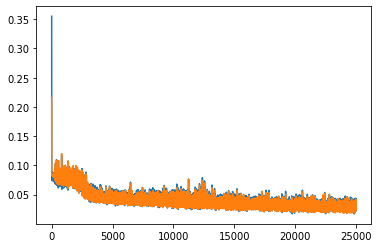

In [ ]:
#saving cost data and plotting
np.save('c3.npy',np.array([costtc3,costvc3]))
data8=np.load("c3.npy")
plt.plot(data8[0])
plt.plot(data8[1])
plt.show()

# Comparing Learning Curves for learning rate

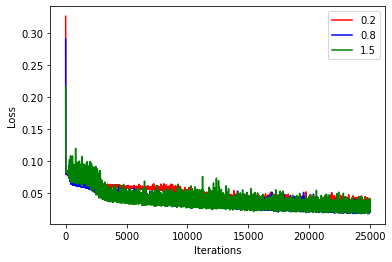

In [ ]:
#plotting validation cost for different learning rate

import matplotlib.pyplot as plt

plt.plot(data6[1], "-r", label="0.2")
plt.plot(data7[1], "-b", label="0.8")
plt.plot(data8[1], "-g", label="1.5")


plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.legend(loc="upper right")

plt.show()


# INFERENCE
We observe from the results that the lower or say smaller the learning rate better the NN will predict the above image
But at the same time if learning rate is too small or too big then it is difficult for the NN to accurately predict the image.
As is the case with learning rate 0.2(too small) and 1.5(very large) in both the cases loss of information is high.
#The NN with learning rate 0.8 is best for us.